In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from latent_geometry.model.mnist_vae import load_decoder
from optim_summary import (
    optimize,
    summarize_path,
    create_summary_fig,
    run,
    run_setup,
    main,
)
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from torch.optim import SGD

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
DEVICE = "cuda"
decoder = load_decoder(DEVICE, "beta_10_decoder.pt")

In [5]:
def show_digits(zss: list[tuple[torch.Tensor, ...]], names: list[str] = None):
    fig, axs = plt.subplots(1, len(zss), figsize=(16, 4))
    for i, zs in enumerate(zss):
        xs = []
        for z in zs:
            with torch.no_grad():
                x = decoder.decode(z).cpu().numpy().reshape(32, 32)
            xs.append(x)
        img = np.concatenate(xs, axis=0)
        ax = axs[i] if len(zss) > 1 else axs
        ax.imshow(img, vmin=0, vmax=1)
        if names:
            ax.set_title(
                names[i],
                fontsize=8,
            )
        ax.set_axis_off()

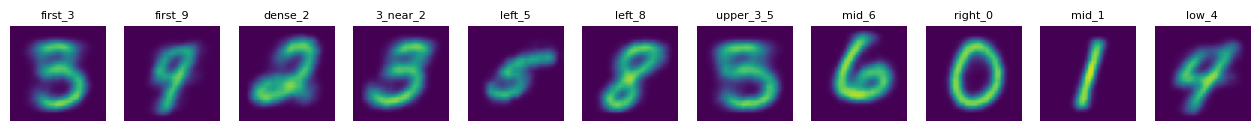

In [7]:
points = {
    "first_3": [0.2, 0.1],
    "first_9": [0.5, -1],
    "dense_2": [-0.54, 0.25],
    "3_near_2": [-0.47, -0.04],
    "left_5": [-1.41, -0.42],
    "left_8": [-0.62, -0.72],
    "upper_3_5": [0.28, 0.37],
    "mid_6": [-0.6, 1.13],
    "right_0": [-1.15, 1.29],
    "mid_1": [-0.87, -1.45],
    "low_4": [0.95, -0.8],
    "mid_4": [0.95, -0.38],
    "upper_4": [0.95, 0.68],
    "centre": [0, 0],
}
COOL_POINTS = {
    k: torch.tensor(v, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    for k, v in points.items()
}
zss, names = zip(*[(tuple(v[None, :]), k) for k, v in COOL_POINTS.items()])
show_digits(zss, names=names)

In [8]:
SETUP = [("standard", 0.005), ("geometric", 0.7), ("retractive", 0.05)]

In [29]:
with torch.no_grad():
    TARGET_6 = decoder.decode(COOL_POINTS["mid_6"]).reshape(1, 32, 32)

In [30]:
TARGET_6.requires_grad

False

In [37]:
darkness = ("darkness", lambda x: 1 - x.mean(), 1.0)
brightness = ("brightness", lambda x: x.mean(), 1.0)
entropy = ("entropy", lambda x: -x.log().mean(), 0.04)
neg_entropy = ("negative entropy", lambda x: x.log().mean(), 0.04)
sixness = ("sixness", lambda x: ((x - TARGET_6) ** 2).mean().sqrt(), 2.0)

In [38]:
# img = run(
#     COOL_POINTS["3_near_2"],
#     n_iter=2000,
#     loss=darkness,
#     map_fn=decoder.decode,
#     optim_setup=SETUP,
# )

In [39]:
main(
    model_name="beta_10",
    latent_dim=2,
    n_iter=2_000,
    optim_setup=SETUP,
    losses=[brightness, sixness],
    tag="randn",
    points=torch.randn(20, 1, 2).cuda(),
)

0it [00:00, ?it/s]

20it [28:46, 86.34s/it]


TODO: more dims + t-sne